In [173]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np

import sklearn as sk

import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
# load in data
data_path='../data_extraction/data/'

cohort = pd.read_table(data_path+'cohort.tsv')
maps = pd.read_csv(data_path+'map.csv')
creatinine = pd.read_csv(data_path+'creatinine.csv')
admission_creatinine = pd.read_csv(data_path+'admission_creatinine.csv')
urine = pd.read_csv(data_path+'map.csv')

In [89]:
# numerical variable summaries
print cohort[['age','los','max_lactate','vaso_frac']].describe()
num_patients = len(cohort['icustay_id'].value_counts().index)
print "Number of patients:", num_patients

               age          los    max_lactate    vaso_frac
count  4524.000000  4524.000000    3806.000000  4524.000000
mean     71.747779    11.261746     265.836206     0.126571
std      49.372594    10.173799   16209.284487     0.206193
min      18.138720     3.001000       0.500000     0.000000
25%      52.214011     4.806700       1.500000     0.000000
50%      64.832726     7.866900       2.200000     0.005086
75%      77.139341    13.936425       3.600000     0.182055
max     309.777981   173.072500  999999.000000     0.995077
Number of patients: 4524


In [90]:
# gender summary
print pd.value_counts(cohort['gender'].values,normalize=True)

F    0.501768
M    0.498232
dtype: float64


In [91]:
# ethnicity summary
eth = cohort['ethnicity'].astype('category')

# grouping based on the standards at: http://grants.nih.gov/grants/guide/notice-files/NOT-OD-15-089.html
eth = eth.cat.add_categories(['HISPANIC/LATINO','MULTI/OTHER','UNKNOWN'])

eth[np.array([('HISPANIC' in i or
               'PORTUGUESE' in i) for i in eth],dtype=bool)]='HISPANIC/LATINO'
eth[np.array([('ASIAN' in i) for i in eth],dtype=bool)]='ASIAN'
eth[np.array([('BLACK' in i or
               'AFRICAN' in i) for i in eth],dtype=bool)]='BLACK/AFRICAN AMERICAN'
eth[np.array([('WHITE' in i or
               'MIDDLE EAST' in i) for i in eth],dtype=bool)]='WHITE'
eth[np.array([('MULTI' in i or
               'OTHER' in i) for i in eth],dtype=bool)]='MULTI/OTHER'
eth[np.array([('DECLINE' in i or
               'UNABLE' in i or
               'UNKNOWN' in i) for i in eth],dtype=bool)]='UNKNOWN'

eth = eth.cat.remove_unused_categories()

print pd.value_counts(eth.values,normalize=True,sort=False)

AMERICAN INDIAN/ALASKA NATIVE    0.000442
ASIAN                            0.021662
BLACK/AFRICAN AMERICAN           0.065429
WHITE                            0.731874
HISPANIC/LATINO                  0.032051
MULTI/OTHER                      0.025199
UNKNOWN                          0.123342
dtype: float64


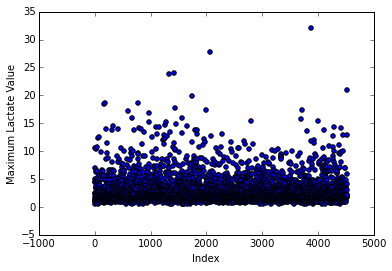

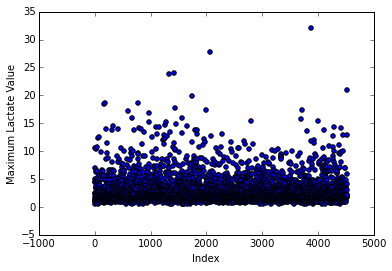

In [167]:
# clean lactate outliers

#before cleaning
plt.figure()
plt.scatter(cohort.index,cohort['max_lactate'])
plt.xlabel('Index')
plt.ylabel('Maximum Lactate Value')

cohort = cohort.loc[cohort['max_lactate'] < 100]
cohort = cohort[pd.notnull(cohort['max_lactate'])]

#after cleaning
plt.figure()
plt.scatter(cohort.index,cohort['max_lactate'])
plt.xlabel('Index')
plt.ylabel('Maximum Lactate Value')

In [183]:
# convert raw MAP readings to MAP features
interval = 60

# average MAP for every hour
maps.set_index('icustay_id')
maps['hour'] = pd.Series((maps.min_from_intime/interval).astype(int), index=maps.index)

# get means for every hour
mean_maps = maps.groupby(['icustay_id', 'hour'])['value'].mean()
mean_maps = mean_maps.to_frame().reset_index().set_index(['icustay_id'])

# interpolate MAPs for missing values
min_hours = mean_maps.groupby([mean_maps.index.get_level_values(0)])['hour'].min()
max_hours = mean_maps.groupby([mean_maps.index.get_level_values(0)])['hour'].max()

interp_index = []
for this_icustay in min_hours.index:
    min_hour = min_hours.loc[this_icustay]
    max_hour = max_hours.loc[this_icustay]
    interp_index += [(this_icustay, hour) for hour in np.arange(min_hour,max_hour+1)]

mean_maps = mean_maps.set_index(['hour'],append=True)
interp_mean_maps = mean_maps.reindex(pd.MultiIndex.from_tuples(interp_index,names=['icustay_id','hour']))
interp_mean_maps = interp_mean_maps['value'].interpolate(method='linear')
interp_mean_maps = interp_mean_maps.to_frame().reset_index()

# get percent of hours missing a MAP value
missing_map = len(interp_mean_maps.index) - len(mean_maps.index)

frac_missing = missing_map/float(len(interp_mean_maps.index))
print "Fraction of hours missing MAP values:", frac_missing

# bin MAP values for first 72 hours
map_72 = interp_mean_maps.loc[(0<interp_mean_maps['hour']) & (interp_mean_maps['hour']<72)]

# get minimum MAP value per patient
min_ind = map_72.groupby('icustay_id')['value'].idxmin(skipna=True)
min_maps = map_72.loc[min_ind]

map_cutoffs = np.append(np.arange(30,100,10),200)
map_72['bin'] = pd.cut(map_72['value'], map_cutoffs)
min_maps['bin'] = pd.cut(min_maps['value'], map_cutoffs)

map_fracs = map_72.groupby('icustay_id')['bin'].value_counts(normalize=True)

# reformat features to be used in final dataset
min_maps = min_maps.set_index('icustay_id')
map_fracs = map_fracs.to_frame()

Fraction of hours missing MAP values: 0.0739482307313


In [94]:
# use creatinine measurements to determine AKI onset
creatinine = creatinine.dropna()

# only consider creatinine measurements after admission
creatinine = creatinine.loc[creatinine['min_from_intime']>0]

# calculate time and first creatinine measurement from admission
creatinine = creatinine.merge(admission_creatinine,suffixes=('','_ref'),on=['icustay_id'],how='left')

# RIFLE Creatinine Criteria: Creatinine doubles
creatinine['I'] = creatinine['value']>=2*creatinine['value_ref']
creatinine['F'] = creatinine['value']>=3*creatinine['value_ref']

# Group creatinine measurements by icustay_id
icustay_creat = creatinine.groupby(['icustay_id'])

# Find the first time the patient meets the RIFLE creatinine criteria 
i_creat_ind = icustay_creat['I'].apply(lambda x: x[x].index[0] if len(x[x])>0 else None)
f_creat_ind = icustay_creat['F'].apply(lambda x: x[x].index[0] if len(x[x])>0 else None)

i_creat = creatinine[['icustay_id','min_from_intime','value']].ix[i_creat_ind.dropna().tolist()]
i_creat = i_creat.set_index('icustay_id')
i_creat.rename(columns={'value':'i_val','min_from_intime':'i_time'},inplace=True)

f_creat = creatinine[['icustay_id','min_from_intime','value']].ix[f_creat_ind.dropna().tolist()]
f_creat = f_creat.set_index('icustay_id')
f_creat.rename(columns={'value':'f_val','min_from_intime':'f_time'},inplace=True)

# also get max creatinine value within time window
max_creat = creatinine.loc[icustay_creat['value'].idxmax(skipna=True)]

# nicely summarize creatinine data
d = {'icustay_id':max_creat['icustay_id'],
     'ref_value':max_creat['value_ref'],
     'ref_time':max_creat['min_from_intime_ref'],
     'max_value':max_creat['value'],
     'max_time':max_creat['min_from_intime']}
creat_summary = pd.DataFrame(d)
creat_summary = creat_summary.set_index('icustay_id')

creat_summary = creat_summary.join(i_creat,how='left')
creat_summary = creat_summary.join(f_creat,how='left')
creat_summary['creat_aki']=pd.notnull(creat_summary['i_val'])

In [184]:
# compile dataset which only includes features for final analysis
lr_data = cohort[['icustay_id','age','los','max_lactate','vaso_frac','gender']]
lr_data['eth'] = eth
lr_data = lr_data.set_index('icustay_id')

lr_data = lr_data.join(min_maps,how='inner')
lr_data.rename(columns={'value':'min_map','bin':'min_map_bin'},inplace=True)

lr_data = lr_data.join(creat_summary['creat_aki'],how='left')

# for now, ignore urine output criteria
lr_data['urine_aki'] = False

lr_data['aki'] = (lr_data['urine_aki'] | creat_summary['creat_aki'])

aki_dataset = lr_data.loc[lr_data['aki']==True]
non_aki_dataset = lr_data.loc[lr_data['aki']==False]

In [185]:
# get summaries of each dataset
def get_summary(dataset):
    print dataset[['age','los','max_lactate','vaso_frac','min_map']].describe()
    print ""
    
    print "gender:"
    print pd.value_counts(dataset['gender'].values)
    print ""
    print pd.value_counts(dataset['gender'].values,normalize=True)
    print ""
    
    print "ethnicity:"
    print pd.value_counts(dataset['eth'].values)
    print ""
    print pd.value_counts(dataset['eth'].values,normalize=True)
    print ""

#AKI
print "------------------------------- AKI Patients -------------------------------"
print "============================================================================"
get_summary(aki_dataset)

#Non-AKI
print "----------------------------- Non-AKI Patients -----------------------------"
print "============================================================================"
get_summary(non_aki_dataset)

#Overall
print "------------------------------- All Patients -------------------------------"
print "============================================================================"
get_summary(lr_data)

------------------------------- AKI Patients -------------------------------
              age         los  max_lactate   vaso_frac     min_map
count  595.000000  595.000000   595.000000  595.000000  595.000000
mean    66.563588   17.832768     4.169748    0.228019   55.913626
std     35.806018   13.516671     3.740189    0.259661    7.390372
min     18.740218    3.060800     0.600000    0.000000   31.000000
25%     51.777648    7.666500     1.700000    0.009382   51.500000
50%     64.772534   13.524400     2.700000    0.135189   55.333333
75%     75.073222   24.957750     5.300000    0.349274   60.000000
max    309.631101   97.489700    27.700000    0.995077   80.500000

gender:
M    319
F    276
dtype: int64

M    0.536134
F    0.463866
dtype: float64

ethnicity:
WHITE                            430
UNKNOWN                           73
BLACK/AFRICAN AMERICAN            38
HISPANIC/LATINO                   23
ASIAN                             16
MULTI/OTHER                       14
AM

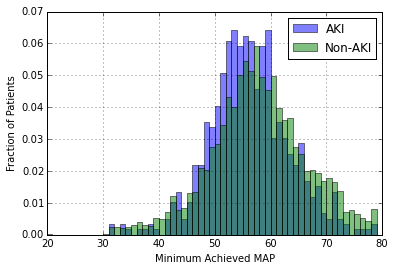

In [202]:
# Look at MAP split between AKI and Non-AKI subsets
bins = np.arange(20,80,1)

aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='AKI',normed=True)
non_aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='Non-AKI',normed=True)

plt.legend(loc='upper right')
plt.xlabel('Minimum Achieved MAP')
plt.ylabel('Fraction of Patients')
plt.show()

In [194]:
# Organize data for logistic regression
train_cols = lr_data[['age','gender','eth','los','max_lactate','vaso_frac','binned_min_map']]
train_cols['gender'] = pd.Categorical(train_cols['gender'])
train_cols['eth'] = pd.Categorical(train_cols['eth'])

train_cols['gender'] = train_cols.gender.cat.codes
train_cols['eth'] = train_cols.eth.cat.codes

# Manually add the intercept
train_cols['intercept'] = 1.0

# Do logistic regression
logit = sm.Logit(lr_data['aki'], train_cols)
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.379094
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    aki   No. Observations:                 3773
Model:                          Logit   Df Residuals:                     3765
Method:                           MLE   Df Model:                            7
Date:                Sun, 04 Dec 2016   Pseudo R-squ.:                  0.1302
Time:                        15:32:50   Log-Likelihood:                -1430.3
converged:                       True   LL-Null:                       -1644.4
                                        LLR p-value:                 2.160e-88
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
age            -0.0032      0.001     -2.621      0.009        -0.006    -0.001
gender          0.1810    

In [195]:
# Get odds ratios
print np.exp(result.params)

age            0.996789
gender         1.198450
eth            0.984101
los            1.060159
max_lactate    1.134814
vaso_frac      5.012505
min_map        0.972177
intercept      0.264953
dtype: float64
